<a href="https://www.kaggle.com/code/fotimakhongulomova/dogs-vs-cats?scriptVersionId=160141964" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture --no-display
!pip install tensorflow
import warnings
warnings.filterwarnings('ignore')

# Notebook Imports

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Unzipping Files from train.zip, test.zip

In [3]:
os.makedirs('/kaggle/working/train')
os.makedirs('/kaggle/working/test')

In [4]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [5]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working/train

In [6]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [7]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working/test

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available 1


### Data Preparation

In [9]:
# Organize data into train, valid, test dirs
os.chdir('/kaggle/working/')

if os.path.isdir('train_set/dog') is False:
    os.makedirs('train_set/dog')
    os.makedirs('train_set/cat')
    os.makedirs('valid_set/dog')
    os.makedirs('valid_set/cat')
    os.makedirs('test_set/cat')
    os.makedirs('test_set/dog')
    
try:
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 500):
        shutil.move(c, 'train_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 500):
        shutil.move(c, 'train_set/dog')
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 100):
        shutil.move(c, 'valid_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 100):
        shutil.move(c, 'valid_set/dog')
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 50):
        shutil.move(c, 'test_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 50):
        shutil.move(c, 'test_set/dog')

except Exception as e:
    print(f"An error occurred: {e}")

os.chdir('../..')

In [10]:
train_set_path = "/kaggle/working/train_set"
test_set_path = "/kaggle/working/test_set"
valid_set_path = "/kaggle/working/valid_set"

In [11]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [12]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100

In [13]:
imgs, labels = next(train_batches)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

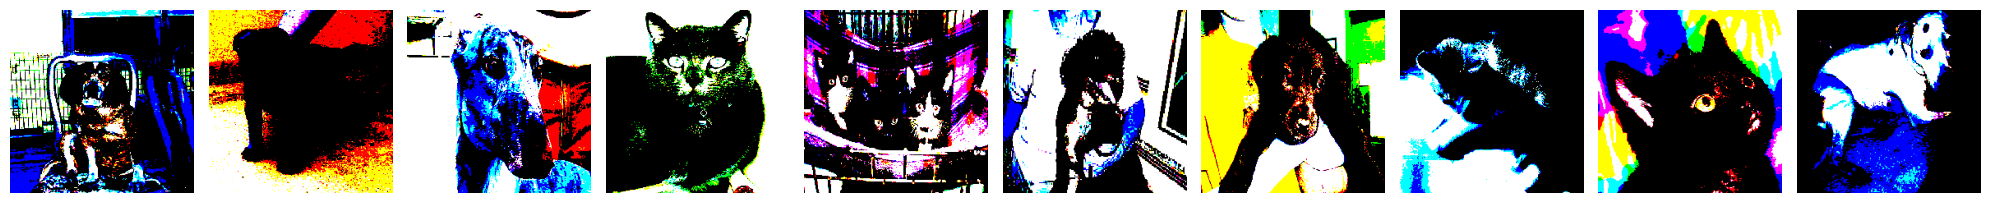

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [15]:
plotImages(imgs)
print(labels)

## Build and Train a CNN

In [16]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 6s - loss: 34.5224 - accuracy: 0.5890 - val_loss: 26.0263 - val_accuracy: 0.6200 - 6s/epoch - 62ms/step
Epoch 2/10
100/100 - 3s - loss: 17.4240 - accuracy: 0.6720 - val_loss: 20.6912 - val_accuracy: 0.5950 - 3s/epoch - 27ms/step
Epoch 3/10
100/100 - 3s - loss: 7.9958 - accuracy: 0.7760 - val_loss: 20.5296 - val_accuracy: 0.6050 - 3s/epoch - 27ms/step
Epoch 4/10
100/100 - 3s - loss: 4.6934 - accuracy: 0.8480 - val_loss: 20.1513 - val_accuracy: 0.5900 - 3s/epoch - 27ms/step
Epoch 5/10
100/100 - 3s - loss: 3.9063 - accuracy: 0.8660 - val_loss: 16.3526 - val_accuracy: 0.6000 - 3s/epoch - 29ms/step
Epoch 6/10
100/100 - 3s - loss: 1.1422 - accuracy: 0.9380 - val_loss: 14.9989 - val_accuracy: 0.6050 - 3s/epoch - 26ms/step
Epoch 7/10
100/100 - 3s - loss: 0.6462 - accuracy: 0.9550 - val_loss: 16.5656 - val_accuracy: 0.5800 - 3s/epoch - 26ms/step
Epoch 8/10
100/100 - 3s - loss: 0.4205 - accuracy: 0.9640 - val_loss: 16.4672 - val_accuracy: 0.5950 - 3s/epoch - 26ms/step
Epoch 

## Predict

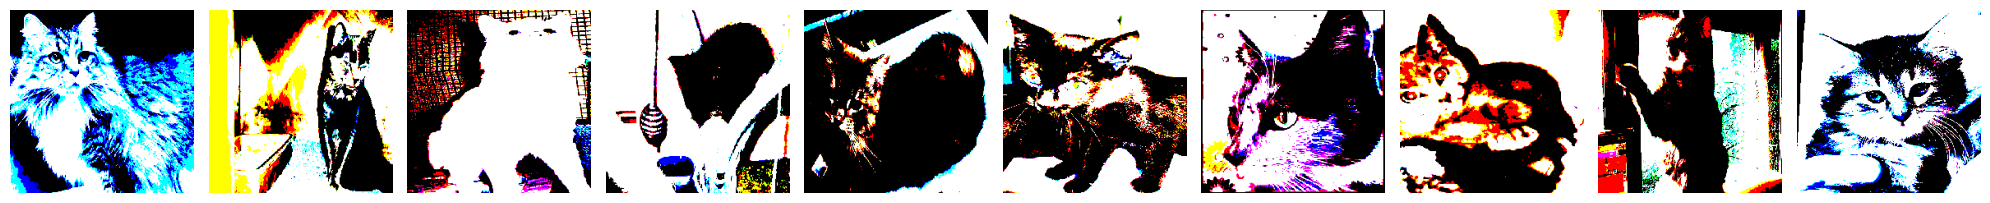

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [20]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [21]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [24]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
labels = ['cat', 'dog']

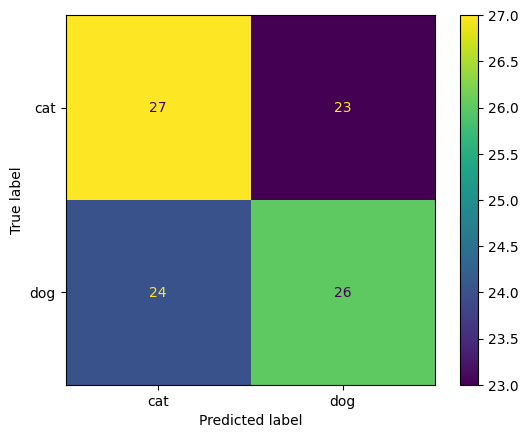

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

## Build Fine-tuned VGG16 model

In [26]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 2s 0us/step


In [27]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [30]:
for layer in model.layers:
    layer.trainable = False

In [31]:
model.add(Dense(units=2, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## Train the fine-tuned VGG16 model

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 6s - loss: 6.2795 - accuracy: 0.4810 - val_loss: 5.7037 - val_accuracy: 0.4800 - 6s/epoch - 57ms/step
Epoch 2/5
100/100 - 4s - loss: 5.4372 - accuracy: 0.4850 - val_loss: 4.8469 - val_accuracy: 0.4800 - 4s/epoch - 35ms/step
Epoch 3/5
100/100 - 3s - loss: 4.6318 - accuracy: 0.4850 - val_loss: 3.9542 - val_accuracy: 0.4800 - 3s/epoch - 35ms/step
Epoch 4/5
100/100 - 4s - loss: 3.8170 - accuracy: 0.4850 - val_loss: 3.0038 - val_accuracy: 0.4800 - 4s/epoch - 35ms/step
Epoch 5/5
100/100 - 4s - loss: 3.0016 - accuracy: 0.4850 - val_loss: 2.1223 - val_accuracy: 0.4800 - 4s/epoch - 36ms/step


## Predict using fine-tuned VGG16 model

In [35]:
predictions = model.predict(x=test_batches, verbose=0)

In [36]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [37]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [38]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [39]:
labels = ['cat', 'dog']

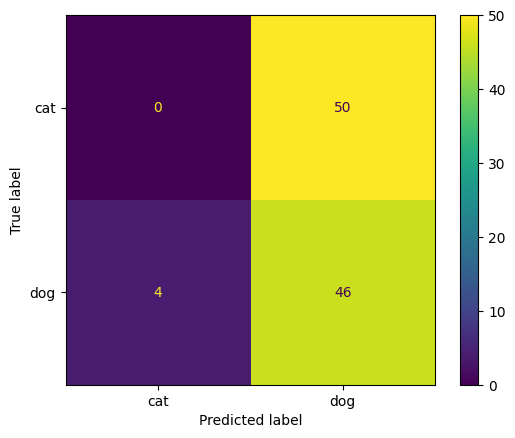

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()